# Results, section 2: correlations between dimensional phenotypes and deviations from normative neurodevelopment

In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
from mpl_toolkits.axes_grid1 import make_axes_locatable

/Users/lindenmp/opt/anaconda3/envs/NormativeNeuroDev_CrossSec_T1/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_T1/code/func/')
from proj_environment import set_proj_env
sys.path.append('/Users/lindenmp/Dropbox/Work/git/pyfunc/')
from func import run_corr, get_fdr_p, run_pheno_correlations, prop_bar_plot, get_sys_summary, get_fdr_p_df, get_sys_prop, update_progress

In [3]:
train_test_str = 'squeakycleanExclude'
exclude_str = 't1Exclude' # 't1Exclude' 'fsFinalExclude'
parc_str = 'schaefer' # 'schaefer' 'lausanne'
parc_scale = 400 # 200 400 | 60 125
primary_covariate = 'ageAtScan1_Years'
extra_str = ''
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(train_test_str = train_test_str, exclude_str = exclude_str,
                                                                            parc_str = parc_str, parc_scale = parc_scale, extra_str = extra_str)

In [4]:
os.environ['NORMATIVEDIR']

'/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_T1/analysis/normative/t1Exclude/squeakycleanExclude/schaefer_400/ageAtScan1_Years+sex_adj'

In [5]:
outdir = os.path.join(os.environ['NORMATIVEDIR'],'analysis_outputs')
if not os.path.exists(outdir): os.makedirs(outdir)

In [6]:
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear']
phenos_label_short = ['Ov. Psych.', 'Psy. (pos.)', 'Psy. (neg.)', 'Anx.-mis.', 'Ext.', 'Fear']
phenos_label = ['Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)','Anxious-Misery','Externalizing','Fear']
metrics = ['ct', 'vol']
metrics_label_short = ['Thickness', 'Volume']
metrics_label = ['Thickness', 'Volume']

## Plots

In [7]:
if not os.path.exists(os.environ['FIGDIR']): os.makedirs(os.environ['FIGDIR'])
os.chdir(os.environ['FIGDIR'])
sns.set(style='white', context = 'paper', font_scale = 1)

## Load data

In [8]:
# Train
df_train = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'train.csv'))
df_train.set_index(['bblid', 'scanid'], inplace = True)
df_node_train = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'resp_train.csv'))
df_node_train.set_index(['bblid', 'scanid'], inplace = True)

# Test
df_test = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'test.csv'))
df_test.set_index(['bblid', 'scanid'], inplace = True)
df_node_test = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'resp_test.csv'))
df_node_test.set_index(['bblid', 'scanid'], inplace = True)

# concat
df = pd.concat((df_train, df_test), axis = 0); print(df.shape)
df_node = pd.concat((df_node_train, df_node_test), axis = 0); print(df_node.shape)

(1393, 51)
(1393, 800)


In [9]:
np.sum(df.loc[:,'sex'] == 1)/df.shape[0]

0.47595118449389806

In [10]:
np.sum(df.loc[:,'squeakycleanExclude'] == 0)

410

In [11]:
np.sum(df.loc[:,'squeakycleanExclude'] == 1)

983

## Load nispat outputs

In [12]:
z_cv = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'cv/Z.txt'), delimiter = ' ').transpose()
df_z_cv = pd.DataFrame(data = z_cv, index = df_node_train.index, columns = df_node_train.columns)

z = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'Z.txt'), delimiter = ' ').transpose()
df_z_test = pd.DataFrame(data = z, index = df_node_test.index, columns = df_node_test.columns)

# concat
df_z = pd.concat((df_z_cv,df_z_test), axis = 0); print(df_z.shape)

(1393, 800)


### Regress age/sex out of psychopathology phenotypes

In [13]:
df_nuis = df.loc[:,[primary_covariate,'sex_adj']]
df_nuis = sm.add_constant(df_nuis)

mdl = sm.OLS(df.loc[:,phenos], df_nuis).fit()
y_pred = mdl.predict(df_nuis)
y_pred.columns = phenos
df.loc[:,phenos] = df.loc[:,phenos] - y_pred

# Note, regressing out age/sex from the deviations as well as the phenotypes makes no difference to the results
# # df_z
# cols = df_z.columns
# mdl = sm.OLS(df_z.loc[:,cols], df_nuis).fit()
# y_pred = mdl.predict(df_nuis)
# y_pred.columns = cols
# df_z.loc[:,cols] = df_z.loc[:,cols] - y_pred

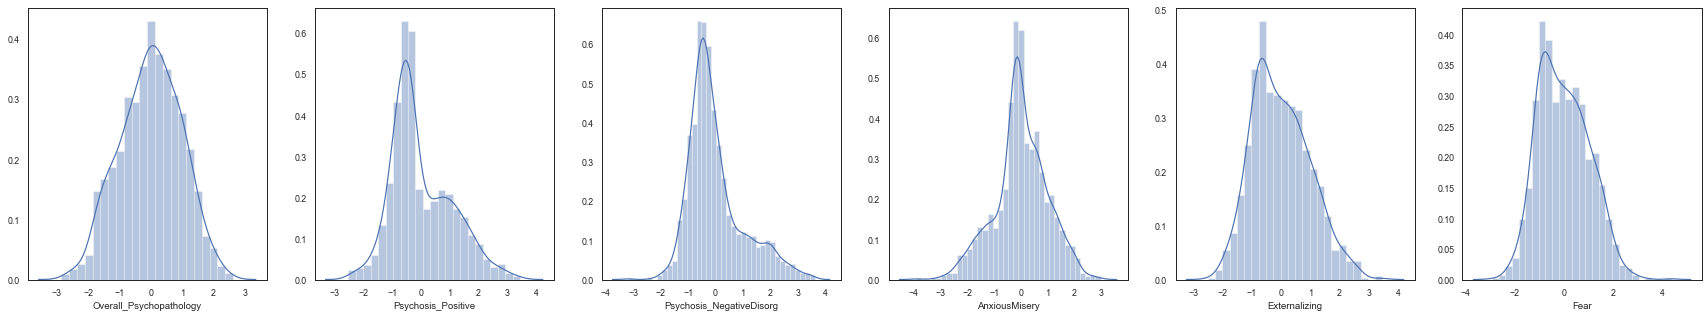

In [14]:
f, ax = plt.subplots(1,len(phenos))
f.set_figwidth(len(phenos)*5)
f.set_figheight(5)

for i, pheno in enumerate(phenos):
    sns.distplot(df.loc[:,pheno], ax = ax[i])
    ax[i].set_xlabel(pheno)

In [15]:
for pheno in phenos:
    print(sp.stats.spearmanr(df.loc[:,'averageManualRating'],df.loc[:,pheno]))

SpearmanrResult(correlation=-0.005016589650007645, pvalue=0.8516082233193734)
SpearmanrResult(correlation=-0.04910549590508256, pvalue=0.06691859971899888)
SpearmanrResult(correlation=-0.026086846266411456, pvalue=0.3305887540984004)
SpearmanrResult(correlation=0.03737679250548465, pvalue=0.16324341812173399)
SpearmanrResult(correlation=-0.02112025099144929, pvalue=0.43090172366867685)
SpearmanrResult(correlation=0.012472449261828444, pvalue=0.6418538573176285)


## Setup region filter
### regions with SMSE <1 in normative model

In [16]:
smse = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'smse.txt'), delimiter = ' ').transpose()
df_smse = pd.DataFrame(data = smse, index = df_z.columns)

In [17]:
smse_thresh = 1
region_filter = df_smse.iloc[:,0] < smse_thresh

In [18]:
region_filter.sum()

747

## Get pheno-nispat relationships

### Regional

In [19]:
method = 'spearman'

In [20]:
assign_p = 'permutation'

In [21]:
if assign_p == 'permutation':
    nulldir = os.path.join(os.environ['NORMATIVEDIR'], 'nulls_z')
#     nulldir = os.path.join(os.environ['NORMATIVEDIR'], 'nulls_z_agesex')
    if not os.path.exists(nulldir): os.makedirs(nulldir)
    df_pheno_z = run_pheno_correlations(df.loc[:,phenos], df_z, method = method, assign_p = assign_p, nulldir = nulldir)
elif assign_p == 'parametric':
    df_pheno_z = run_pheno_correlations(df.loc[:,phenos], df_z, method = method, assign_p = assign_p)

In [22]:
# correct multiple comparisons. We do this across brain regions and phenotypes (e.g., 400*6 = 2400 tests)
df_p_corr = pd.DataFrame(index = df_pheno_z.index, columns = ['p-corr']) # output dataframe

for metric in metrics:
    p_corr = get_fdr_p(df_pheno_z.loc[:,'p'].filter(regex = metric)) # correct p-values for metric
    p_corr_tmp = pd.DataFrame(index = df_pheno_z.loc[:,'p'].filter(regex = metric).index, columns = ['p-corr'], data = p_corr) # set to dataframe with correct indices
    df_pheno_z.loc[p_corr_tmp.index, 'p-corr'] = p_corr_tmp # store using index matching

In [23]:
for pheno in phenos:
    for metric in metrics:
        print(pheno, metric, np.sum(df_pheno_z.filter(regex = metric, axis = 0).filter(regex = pheno, axis = 0).loc[:,'p-corr'] < .05) / num_parcels * 100, '% significant effects (fdr)')
    print('')

Overall_Psychopathology ct 4.75 % significant effects (fdr)
Overall_Psychopathology vol 33.75 % significant effects (fdr)

Psychosis_Positive ct 6.25 % significant effects (fdr)
Psychosis_Positive vol 17.75 % significant effects (fdr)

Psychosis_NegativeDisorg ct 0.0 % significant effects (fdr)
Psychosis_NegativeDisorg vol 9.75 % significant effects (fdr)

AnxiousMisery ct 0.0 % significant effects (fdr)
AnxiousMisery vol 3.0 % significant effects (fdr)

Externalizing ct 1.25 % significant effects (fdr)
Externalizing vol 11.75 % significant effects (fdr)

Fear ct 12.75 % significant effects (fdr)
Fear vol 22.75 % significant effects (fdr)



In [24]:
alpha = 0.05
print(alpha)

0.05


In [25]:
x = df_pheno_z['p-corr'].values < alpha
df_pheno_z['sig'] = x

x = x.reshape(1,-1)
y = np.matlib.repmat(region_filter, 1, len(phenos))

my_bool = np.concatenate((x, y), axis = 0); region_filt = np.all(my_bool, axis = 0); df_pheno_z['sig_smse'] = region_filt

print(str(np.sum(df_pheno_z['sig'] == True)) + ' significant effects (fdr)')
print(str(np.sum(df_pheno_z['sig_smse'] == True)) + ' significant effects (fdr)')

495 significant effects (fdr)
463 significant effects (fdr)


In [26]:
for pheno in phenos:
    for metric in metrics:
        print(pheno, metric, np.sum(df_pheno_z.loc[pheno,'sig_smse'].filter(regex = metric) == True) / num_parcels * 100, '% significant effects (fdr)')
    print('')

Overall_Psychopathology ct 3.75 % significant effects (fdr)
Overall_Psychopathology vol 32.25 % significant effects (fdr)

Psychosis_Positive ct 5.5 % significant effects (fdr)
Psychosis_Positive vol 16.5 % significant effects (fdr)

Psychosis_NegativeDisorg ct 0.0 % significant effects (fdr)
Psychosis_NegativeDisorg vol 9.5 % significant effects (fdr)

AnxiousMisery ct 0.0 % significant effects (fdr)
AnxiousMisery vol 3.0 % significant effects (fdr)

Externalizing ct 1.0 % significant effects (fdr)
Externalizing vol 11.5 % significant effects (fdr)

Fear ct 10.0 % significant effects (fdr)
Fear vol 22.75 % significant effects (fdr)



In [27]:
metric = 'vol'

In [28]:
vals = np.zeros(len(phenos))

for p, pheno in enumerate(phenos):
    vals[p] = np.sum(df_pheno_z.loc[pheno,'sig_smse'].filter(regex = metric) == True) / num_parcels * 100

idx_perc_sig = np.argsort(vals)[::-1]

phenos_ordered = [phenos[i] for i in idx_perc_sig]
phenos_label_ordered = [phenos_label[i] for i in idx_perc_sig]

phenos_ordered

['Overall_Psychopathology',
 'Fear',
 'Psychosis_Positive',
 'Externalizing',
 'Psychosis_NegativeDisorg',
 'AnxiousMisery']

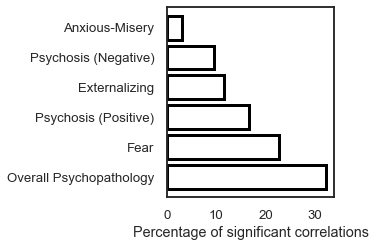

In [29]:
sns.set(style='white', context = 'talk', font_scale = 0.8)
f, ax = plt.subplots()
f.set_figwidth(3)
f.set_figheight(3.5)

ax.barh(y = np.arange(len(phenos)), width = vals[idx_perc_sig], color = 'white', edgecolor = 'black', linewidth = 3)
ax.set_yticks(np.arange(len(phenos)))
ax.set_yticklabels(phenos_label_ordered)
ax.set_xlabel('Percentage of significant correlations')
f.savefig('perce_sig_corrs', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

## Save out

In [30]:
df.to_csv(os.path.join(outdir,'df.csv'))
df_z.to_csv(os.path.join(outdir,'df_z.csv'))
df_pheno_z.to_csv(os.path.join(outdir,'df_pheno_z.csv'))
region_filter.to_csv(os.path.join(outdir,'region_filter.csv'))

## Summarise effects over Yeo networks

In [31]:
sns.set(style='white', context = 'paper', font_scale = 0.9)

Overall_Psychopathology
Thickness


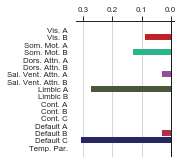

Volume


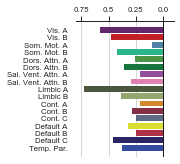

Psychosis_Positive
Thickness


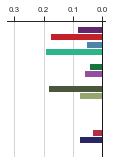

Volume


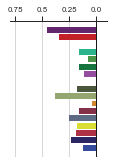

Psychosis_NegativeDisorg
Thickness


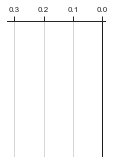

Volume


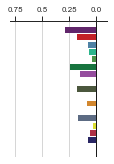

AnxiousMisery
Thickness


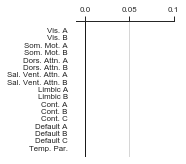

Volume


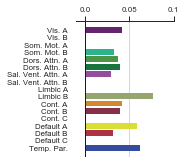

Externalizing
Thickness


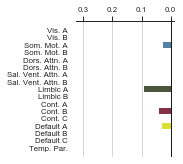

Volume


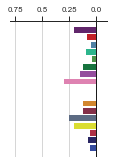

Fear
Thickness


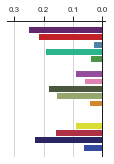

Volume


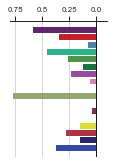

In [32]:
if parc_str == 'schaefer' and parc_scale == 400:
    for i, pheno in enumerate(phenos):
        print(pheno)
        pheno_label = phenos_label[i]
        for j, metric in enumerate(metrics):
            metric_label = metrics_label[j]
            print(metric_label)

            # Get coefficients and p-vals for phenotype effects
            coef = df_pheno_z.loc[pheno].filter(regex = metric, axis = 0)['coef'].values
            p_vals = np.zeros(coef.shape,)
            sig = df_pheno_z.loc[pheno].filter(regex = metric, axis = 0)['sig_smse'].values; p_vals[~sig] = 1  # only plot significant coefficients
            sys_prop = get_sys_prop(coef, p_vals, yeo_idx, alpha = alpha)

            if pheno == 'AnxiousMisery': my_axlim = [-0.01,0.1]
            elif metric == 'ct': my_axlim = [-0.325,0.01]
            else: my_axlim = [-0.8,0.1]

            if pheno == 'Overall_Psychopathology' or pheno == 'AnxiousMisery': my_labels = yeo_labels
            elif metric == 'ct' and pheno == 'Externalizing': my_labels = yeo_labels
            else: my_labels = ''

            f, ax = prop_bar_plot(sys_prop, np.ones(sys_prop.shape), labels = my_labels, which_colors = 'yeo17', axlim = my_axlim, title_str = '', fig_size = [1.75,2.5])
            f.savefig('corr_bar_' + pheno + '_' + metric + '_z.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

In [33]:
import matplotlib.image as mpimg
from brain_plot_func import roi_to_vtx, brain_plot

In [34]:
if parc_str == 'schaefer':
    subject_id = 'fsaverage'
elif parc_str == 'lausanne':
    subject_id = 'lausanne125'

In [35]:
%pylab qt

Populating the interactive namespace from numpy and matplotlib


/Users/lindenmp/opt/anaconda3/envs/NormativeNeuroDev_CrossSec_T1/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Brain plots

In [36]:
for metric in metrics:
    for hemi in ('lh', 'rh'):
        print(metric)
        # Plots of univariate pheno correlation
        fig_str = hemi + '_' + metric + '_region_filter'
        roi_data = region_filter.filter(regex = metric, axis = 0).astype(float).values
        roi_data[roi_data == 1] = -1000
        roi_data[roi_data == 0] = 1

        if subject_id == 'lausanne125':
            parc_file = os.path.join('/Applications/freesurfer/subjects/', subject_id, 'label', hemi + '.myaparc_' + str(parc_scale) + '.annot')
        elif subject_id == 'fsaverage':
            parc_file = os.path.join('/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_T1/figs_support/Parcellations/FreeSurfer5.3/fsaverage/label/',
                                     hemi + '.Schaefer2018_' + str(parc_scale) + 'Parcels_17Networks_order.annot')

        # project subject's data to vertices
        brain_plot(roi_data, parcel_names, parc_file, fig_str, subject_id = subject_id, hemi = hemi, surf = 'inflated', center_anchor = 1, color = 'hot')

ct
colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
ct
colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
vol
colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
vol
colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)


In [37]:
for pheno in phenos:
    for metric in metrics:
        for hemi in ('lh', 'rh'):
            print(pheno, metric)
            # Plots of univariate pheno correlation
            fig_str = hemi + '_' + pheno + '_' + metric + '_z'
            roi_data = df_pheno_z.loc[pheno].filter(regex = metric, axis = 0)['coef'].values
            sig = df_pheno_z.loc[pheno].filter(regex = metric, axis = 0)['sig_smse']
            roi_data[~sig] = -1000

            if subject_id == 'lausanne125':
                parc_file = os.path.join('/Applications/freesurfer/subjects/', subject_id, 'label', hemi + '.myaparc_' + str(parc_scale) + '.annot')
            elif subject_id == 'fsaverage':
                parc_file = os.path.join('/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_T1/figs_support/Parcellations/FreeSurfer5.3/fsaverage/label/',
                                         hemi + '.Schaefer2018_' + str(parc_scale) + 'Parcels_17Networks_order.annot')

            # project subject's data to vertices
            brain_plot(roi_data, parcel_names, parc_file, fig_str, subject_id = subject_id, hemi = hemi, surf = 'inflated', center_anchor = 0.2)

Overall_Psychopathology ct
0.2
colormap divergent: center=0.00e+00, [0.00e+00, 1.00e-01, 2.00e-01] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 1.00e-01, 2.00e-01] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 1.00e-01, 2.00e-01] (opaque)
Overall_Psychopathology ct
0.2
colormap divergent: center=0.00e+00, [0.00e+00, 1.00e-01, 2.00e-01] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 1.00e-01, 2.00e-01] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 1.00e-01, 2.00e-01] (opaque)
Overall_Psychopathology vol
0.2
colormap divergent: center=0.00e+00, [0.00e+00, 1.00e-01, 2.00e-01] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 1.00e-01, 2.00e-01] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 1.00e-01, 2.00e-01] (opaque)
Overall_Psychopathology vol
0.2
colormap divergent: center=0.00e+00, [0.00e+00, 1.00e-01, 2.00e-01] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 1.00e-01, 2.00e-01] (opaque)
colormap divergent: center=

In [38]:
%matplotlib inline

# Figure 3

Overall_Psychopathology
ct


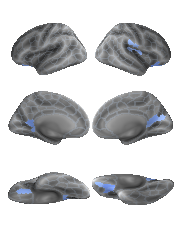

Overall_Psychopathology
vol


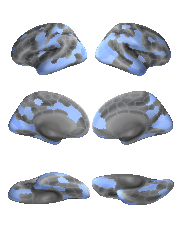

Psychosis_Positive
ct


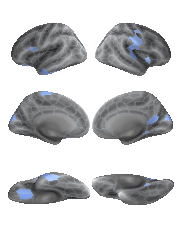

Psychosis_Positive
vol


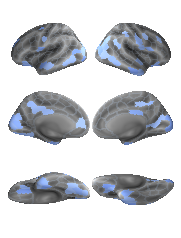

Psychosis_NegativeDisorg
ct


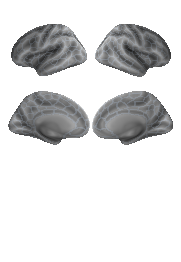

Psychosis_NegativeDisorg
vol


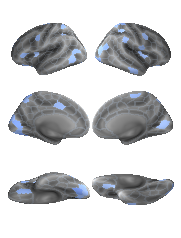

AnxiousMisery
ct


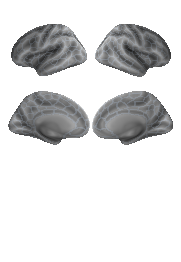

AnxiousMisery
vol


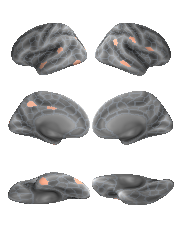

Externalizing
ct


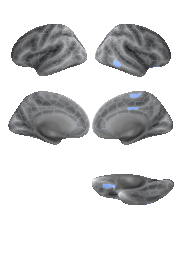

Externalizing
vol


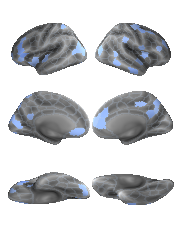

Fear
ct


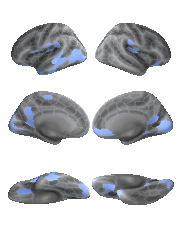

Fear
vol


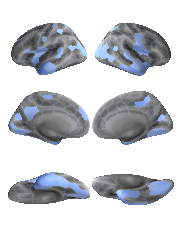

In [39]:
for pheno in phenos:
    for metric in metrics:
        f, axes = plt.subplots(3, 2)
        f.set_figwidth(3)
        f.set_figheight(5)
        plt.subplots_adjust(wspace=0, hspace=-0.465)

        print(pheno)
        print(metric)
        # column 0:
        fig_str = 'lh_'+pheno+'_'+metric+'_z.png'
        try:
            image = mpimg.imread('ventral_' + fig_str); axes[2,0].imshow(image); axes[2,0].axis('off')
        except FileNotFoundError: axes[2,0].axis('off')
        try:
            image = mpimg.imread('med_' + fig_str); axes[1,0].imshow(image); axes[1,0].axis('off')
        except FileNotFoundError: axes[1,0].axis('off')
        try:
        #     axes[0,0].set_title('Thickness (left)')
            image = mpimg.imread('lat_' + fig_str); axes[0,0].imshow(image); axes[0,0].axis('off')
        except FileNotFoundError: axes[0,0].axis('off')


            

        # column 1:
        fig_str = 'rh_'+pheno+'_'+metric+'_z.png'
        try:
        #     axes[0,1].set_title('Thickness (right)')
            image = mpimg.imread('lat_' + fig_str); axes[0,1].imshow(image); axes[0,1].axis('off')
        except FileNotFoundError: axes[0,1].axis('off')
        try:
            image = mpimg.imread('med_' + fig_str); axes[1,1].imshow(image); axes[1,1].axis('off')
        except FileNotFoundError: axes[1,1].axis('off')
        try:
            image = mpimg.imread('ventral_' + fig_str); axes[2,1].imshow(image); axes[2,1].axis('off')
        except FileNotFoundError: axes[2,1].axis('off')

        plt.show()
#         f.savefig(metric+'_'+pheno+'_z.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)
        f.savefig(metric+'_'+pheno+'_z.svg', dpi = 1000, bbox_inches = 'tight', pad_inches = 0)

ct


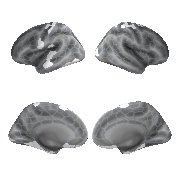

vol


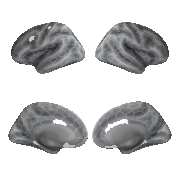

In [40]:
for metric in metrics:
    f, axes = plt.subplots(2, 2)
    f.set_figwidth(3)
    f.set_figheight(3)
    plt.subplots_adjust(wspace=0, hspace=0)

    print(metric)
    # column 0:
    fig_str = 'lh_'+metric+'_region_filter.png'
    try:
        image = mpimg.imread('lat_' + fig_str); axes[0,0].imshow(image); axes[0,0].axis('off')
    except FileNotFoundError: axes[0,0].axis('off')
    try:
        image = mpimg.imread('med_' + fig_str); axes[1,0].imshow(image); axes[1,0].axis('off')
    except FileNotFoundError: axes[1,0].axis('off')

    # column 1:
    fig_str = 'rh_'+metric+'_region_filter.png'
    try:
        image = mpimg.imread('lat_' + fig_str); axes[0,1].imshow(image); axes[0,1].axis('off')
    except FileNotFoundError: axes[0,1].axis('off')
    try:
        image = mpimg.imread('med_' + fig_str); axes[1,1].imshow(image); axes[1,1].axis('off')
    except FileNotFoundError: axes[1,1].axis('off')

    plt.show()
    f.savefig(metric+'_region_filter.svg', dpi = 1000, bbox_inches = 'tight', pad_inches = 0)